# Microwakings Model Multi File
Training a model to detect microwakings, with multiple files.


In [1]:
%reload_ext autoreload
%autoreload 2
import logging
import os

log = lambda msg: logging.info(msg)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [10]:
import sys
sys.path.append('C:\\dev\\play\\brainwave-processor')

import run_yasa
import run_feature_pipeline
from models.microwakings_1.microwakings1 import PerFile
import microwakings1 as helpers
import mne

out_files: list[PerFile] = []
errors = []

for root, dirs, files in os.walk(input_dir):
    for dir_name in dirs:
        input_file = os.path.join(root, dir_name, "raw.fif")
        scoring_file = os.path.join(root, dir_name, "raw.scorings.json")
        try:
            log("Processing file: " + input_file)
            if os.path.exists(input_file) and os.path.exists(scoring_file):
                scoring_df = helpers.load_scoring_file(scoring_file)
                
                if len(scoring_df) == 0:
                    log("No marks data found for file: " + input_file)
                    continue
                    
                input_file_without_ext = os.path.splitext(input_file)[0]
                yasa_df = run_feature_pipeline.cached_pipeline(log, input_file)
                mne_raw = mne.io.read_raw_fif(input_file, preload=True)
                mne_filtered = run_yasa.get_filtered_and_scaled_data(mne_raw)
                out_files.append(PerFile(scoring_df, mne_filtered, yasa_df, input_file_without_ext))
        except Exception as e:
            log("Error processing file: " + input_file)
            errors.append("Error processing file: " + input_file + " - " + str(e))
            log(e)

for err in errors:
    log(err)


2024-09-13 08:28:08,481 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif
2024-09-13 08:28:08,481 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif
2024-09-13 08:28:08,482 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.fif
2024-09-13 08:28:08,484 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.fif
2024-09-13 08:28:08,485 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.fif
2024-09-13 08:28:08,485 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.fif
2024-09-13 08:28:08,486 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.fif
2024-09-13 08:28:08,487 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.fif
2024-09-13 08:28:08,488 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.fif
2024-09-13 08:28:08,489 - INFO - Processing file: C:\de

In [11]:
errors

['Error processing file: C:\\dev\\play\\brainwave-data\\2024-09-01-21-11-15\\raw.fif - "Key \'marks\' not found. If specifying a record_path, all elements of data should have the path."',
 'Error processing file: C:\\dev\\play\\brainwave-data\\2024-09-02-21-42-00\\raw.fif - "Key \'marks\' not found. If specifying a record_path, all elements of data should have the path."']

In [12]:
# from datetime import timedelta
# 
# for file in out_files:
#     file.start_time = file.mne_filtered.info['meas_date']
#     file.sfreq = file.mne_filtered.info['sfreq']
#     file.end_time = file.start_time + timedelta(seconds=float(file.mne_filtered.times[-1]))
# #     file.day_or_night_of = '-'.join(file.input_file_without_ext.split('\\')[-2].split('-')[0:3])


In [13]:
out_files

# Prepare wakings

In [14]:
import pandas as pd
all_wakings = pd.DataFrame()

for file in out_files:
    df = file.prepare_microwakings()
    df['DayOrNightOf'] = file.day_or_night_of
    all_wakings = pd.concat([all_wakings, df])
    
all_wakings

,Start,End,Duration,DayOrNightOf
0,2024-08-19 22:00:38.130000+00:00,2024-08-19 22:00:53.800000+00:00,0 days 00:00:15.670000,2024-08-19
1,2024-08-19 22:01:18.590000+00:00,2024-08-19 22:01:24.319000+00:00,0 days 00:00:05.729000,2024-08-19
2,2024-08-19 22:25:09.760000+00:00,2024-08-19 22:25:20.239000+00:00,0 days 00:00:10.479000,2024-08-19
3,2024-08-19 22:28:33.380000+00:00,2024-08-19 22:28:46.619000+00:00,0 days 00:00:13.239000,2024-08-19
4,2024-08-19 22:39:38.069000+00:00,2024-08-19 22:40:00.119000+00:00,0 days 00:00:22.050000,2024-08-19
...,...,...,...,...
30,2024-08-27 05:39:47.309000+00:00,2024-08-27 05:39:52.300000+00:00,0 days 00:00:04.991000,2024-08-26
31,2024-08-27 05:49:51.430000+00:00,2024-08-27 05:50:15.500000+00:00,0 days 00:00:24.070000,2024-08-26
32,2024-08-27 05:54:32.349000+00:00,2024-08-27 05:55:01.650000+00:00,0 days 00:00:29.301000,2024-08-26
33,2024-08-27 05:57:39.029000+00:00,2024-08-27 05:57:58.949000+00:00,0 days 00:00:19.920000,2024-08-26


In [15]:
grouped = all_wakings.groupby('DayOrNightOf').agg(
    wakings_count=('Duration', 'size'),
    duration_25th=('Duration', lambda x: x.quantile(0.25)),
    duration_50th=('Duration', lambda x: x.quantile(0.50)),
    duration_75th=('Duration', lambda x: x.quantile(0.75))
).reset_index()

for file in out_files:
    loc = grouped['DayOrNightOf'] == file.day_or_night_of
    grouped.loc[loc, 'Start'] = file.start_time
    grouped.loc[loc, 'End'] = file.end_time
    grouped.loc[loc, 'Duration'] = file.end_time - file.start_time

grouped['Wakings Per'] = grouped["wakings_count"] / grouped["Duration"].dt.total_seconds()

grouped

,DayOrNightOf,wakings_count,duration_25th,duration_50th,duration_75th,Start,End,Duration,Wakings Per
0,2024-08-19,71,0 days 00:00:08.851000,0 days 00:00:11.800000,0 days 00:00:15.585000,2024-08-19 20:43:57.085977+00:00,2024-08-20 12:08:02.069977+00:00,0 days 15:24:04.984000,0.001281
1,2024-08-20,68,0 days 00:00:08.043500,0 days 00:00:09.764500,0 days 00:00:12.294750,2024-08-20 20:17:32.914784+00:00,2024-08-21 08:49:01.698784+00:00,0 days 12:31:28.784000,0.001508
2,2024-08-22,85,0 days 00:00:08.550000,0 days 00:00:10.660000,0 days 00:00:12.929000,2024-08-22 20:26:19.368171+00:00,2024-08-23 03:47:50.240171+00:00,0 days 07:21:30.872000,0.003209
3,2024-08-25,87,0 days 00:00:07.011000,0 days 00:00:09.169000,0 days 00:00:14.990000,2024-08-25 20:25:33.907675+00:00,2024-08-26 06:50:18.675675+00:00,0 days 10:24:44.768000,0.002321
4,2024-08-26,35,0 days 00:00:07.634000,0 days 00:00:10.040000,0 days 00:00:15.215000,2024-08-26 19:56:10.722846+00:00,2024-08-27 06:03:38.582846+00:00,0 days 10:07:27.860000,0.000960


In [9]:
# grouped.columns

# Prepare model data

In [16]:
# Training time is horrendous, trying to reduce
resample_rate = 10

for file in out_files:
    df = file.prepare_model_data(resample_rate, True)
    loc = grouped['DayOrNightOf'] == file.day_or_night_of
    microwaking_counts = df['Microwaking'].value_counts()
    grouped.loc[loc, 'MicrowakingSamples'] = microwaking_counts.get(1, 0)
    grouped.loc[loc, 'OtherSamples'] = microwaking_counts.get(0, 0)

grouped['TotalSamples'] = grouped['MicrowakingSamples'] + grouped['OtherSamples']
grouped['MicrowakingSamplesPer'] = grouped['MicrowakingSamples'] / grouped['TotalSamples']
grouped['TotalMins'] = grouped['TotalSamples'] / resample_rate / 60
grouped['TotalHours'] = grouped['TotalMins'] / 60

grouped

,DayOrNightOf,wakings_count,duration_25th,duration_50th,duration_75th,Start,End,Duration,Wakings Per,MicrowakingSamples,OtherSamples,TotalSamples,MicrowakingSamplesPer,TotalMins,TotalHours
0,2024-08-19,71,0 days 00:00:08.851000,0 days 00:00:11.800000,0 days 00:00:15.585000,2024-08-19 20:43:57.085977+00:00,2024-08-20 12:08:02.069977+00:00,0 days 15:24:04.984000,0.001281,4240.0,260410.0,264650.0,0.016021,441.083333,7.351389
1,2024-08-20,68,0 days 00:00:08.043500,0 days 00:00:09.764500,0 days 00:00:12.294750,2024-08-20 20:17:32.914784+00:00,2024-08-21 08:49:01.698784+00:00,0 days 12:31:28.784000,0.001508,5367.0,267921.0,273288.0,0.019639,455.480000,7.591333
2,2024-08-22,85,0 days 00:00:08.550000,0 days 00:00:10.660000,0 days 00:00:12.929000,2024-08-22 20:26:19.368171+00:00,2024-08-23 03:47:50.240171+00:00,0 days 07:21:30.872000,0.003209,5932.0,203477.0,209409.0,0.028327,349.015000,5.816917
3,2024-08-25,87,0 days 00:00:07.011000,0 days 00:00:09.169000,0 days 00:00:14.990000,2024-08-25 20:25:33.907675+00:00,2024-08-26 06:50:18.675675+00:00,0 days 10:24:44.768000,0.002321,7045.0,272103.0,279148.0,0.025238,465.246667,7.754111
4,2024-08-26,35,0 days 00:00:07.634000,0 days 00:00:10.040000,0 days 00:00:15.215000,2024-08-26 19:56:10.722846+00:00,2024-08-27 06:03:38.582846+00:00,0 days 10:07:27.860000,0.000960,2175.0,200604.0,202779.0,0.010726,337.965000,5.632750


# Train model

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K
import gc

# Reset the default graph
tf.compat.v1.reset_default_graph()

# Clear the Keras session
K.clear_session()
tf.keras.backend.clear_session()

# Run garbage collection
gc.collect()

import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory to 4GB (adjust as needed)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
    except RuntimeError as e:
        print(e)


# Limit CPU memory growth
# tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('CPU')[0], True)

# Or set a specific memory limit (e.g., 4GB)
# tf.config.experimental.set_virtual_device_configuration(
#     tf.config.experimental.list_physical_devices('CPU')[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
# )

In [18]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
tf.version.VERSION

'2.10.1'

In [13]:
# from tensorflow.keras import mixed_precision
# 
# # Set the mixed precision policy
# policy = mixed_precision.Policy('float32')
# mixed_precision.set_global_policy(policy)

In [14]:
# tf.get_logger().setLevel(logging.WARNING)
# tf.debugging.set_log_device_placement(False)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [15]:
# import numpy as np
# from sklearn.utils.class_weight import compute_class_weight
# 
# # Compute class weights - way less microwakings (1) than not (0) so they should get a much higher weighting
# all_y = np.concatenate([file.y for file in out_files])
# classes = np.array([0, 1])
# class_weights = compute_class_weight('balanced', classes=classes, y=all_y)
# # class_weight_tensor = tf.constant([class_weights[0], class_weights[1]], dtype=tf.float16)
# class_weight_tensor = tf.constant([class_weights[0], class_weights[1]])
# class_weight_dict = {int(classes[i]): float(class_weight_tensor.numpy()[i]) for i in range(len(classes))}
# assert class_weight_dict[1] > class_weight_dict[0]
# class_weight_dict

Epoch 1/100
5/5 [==============================] - 22s 3s/step - loss: 0.6927 - cross entropy: 0.6927 - Brier score: 0.2498 - tp: 4502.0000 - fp: 184781.0000 - tn: 1019734.0000 - fn: 20257.0000 - accuracy: 0.8332 - precision: 0.0238 - recall: 0.1818 - auc: 0.4985 - prc: 0.0213
Epoch 2/100
5/5 [==============================] - 1s 160ms/step - loss: 0.6915 - cross entropy: 0.6915 - Brier score: 0.2492 - tp: 79.0000 - fp: 77.0000 - tn: 1204438.0000 - fn: 24680.0000 - accuracy: 0.9799 - precision: 0.5064 - recall: 0.0032 - auc: 0.4758 - prc: 0.0193
Epoch 3/100
5/5 [==============================] - 1s 171ms/step - loss: 0.6902 - cross entropy: 0.6902 - Brier score: 0.2485 - tp: 1.0000 - fp: 8.0000 - tn: 1204507.0000 - fn: 24758.0000 - accuracy: 0.9799 - precision: 0.1111 - recall: 4.0389e-05 - auc: 0.4226 - prc: 0.0173
Epoch 4/100
5/5 [==============================] - 1s 163ms/step - loss: 0.6889 - cross entropy: 0.6889 - Brier score: 0.2479 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120451

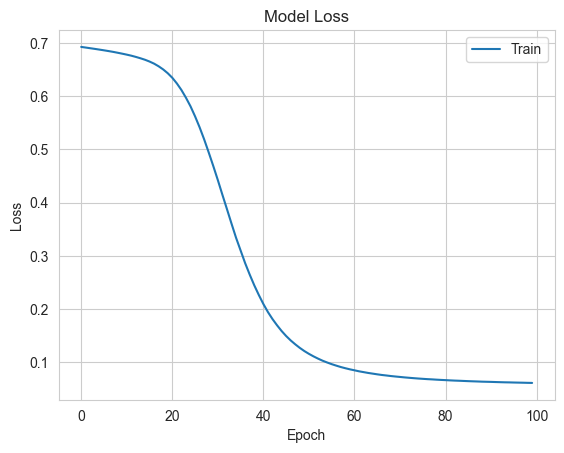

In [16]:
import time
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dense, TimeDistributed, BatchNormalization, LSTM, GRU, Dropout, AveragePooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras as keras

import gc
gc.collect()

class DaySequence(Sequence):
    def __init__(self, out_files):
        self.out_files = out_files

    # Batch size
    def __len__(self):
        return len(self.out_files)

    # Get batch
    def __getitem__(self, idx):
        file = self.out_files[idx]
        X = file.X.reshape(-1, 1) #.astype('float16')  # Convert to float16
        y = file.y.reshape(-1, 1) #.astype('float16')  # Convert to float16
        X_out = X # np.expand_dims(X, axis=0)
        y_out = y # np.expand_dims(y, axis=0)
        # X = file.X.reshape(-1, 1)
        # y = file.y.reshape(-1, 1)
        # X_out = np.expand_dims(X, axis=0)
        #print(f"file = {file.day_or_night_of} X_out.shape = {X_out.shape}, y.shape = {y_out.shape}")
        return X_out, y_out
    
day_sequence = DaySequence(out_files)

model = Sequential([
    Input(shape=(None, 1)),

    # Try to detect features
    Conv1D(32, kernel_size=120, activation='relu', padding='same', name="Conv1D_1"),
    Conv1D(64, kernel_size=60, activation='relu', padding='same', name="Conv1D_2"),
    Conv1D(64, kernel_size=30, activation='relu', padding='same', name="Conv1D_3"),
    Conv1D(32, kernel_size=15, activation='relu', padding='same', name="Conv1D_4"),
    
    # Give it some memory
    LSTM(units=128, return_sequences=True),

    # Temporal pooling to try to encourage it to output the same throughout the waking
    AveragePooling1D(pool_size=10),
    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    UpSampling1D(size=10),

    # Dropout(0.2),
    # LSTM(units=64, return_sequences=True),  
    TimeDistributed(Dense(1, activation='sigmoid'))
])


# 3/3 [==============================] - 15s 2s/step - loss: 4.1520 - cross entropy: 0.6935 - Brier score: 0.2502 - tp: 11283.0000 - fp: 531622.0000 - tn: 144562.0000 - fn: 3869.0000 - accuracy: 0.2254 - precision: 0.0208 - recall: 0.7447 - auc: 0.5248 - prc: 0.0652
# 3/3 [==============================] - 0s 135ms/step - loss: 1.2523 - cross entropy: 1.4580 - Brier score: 0.5408 - tp: 15152.0000 - fp: 676184.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0219 - precision: 0.0219 - recall: 1.0000 - auc: 0.8694 - prc: 0.4497

METRICS = [
    #  difference between the predicted probabilities and the actual class labels.
    keras.metrics.BinaryCrossentropy(name='cross entropy'),
    #  The Brier score measures the accuracy of probabilistic predictions. It ranges from 0 to 1, with lower values indicating better accuracy
    keras.metrics.MeanSquaredError(name='Brier score'),
    # The number of correctly predicted positive samples. 
    keras.metrics.TruePositives(name='tp'),
    # The number of negative samples incorrectly predicted as positive.
    keras.metrics.FalsePositives(name='fp'),
    #  The number of correctly predicted negative samples.
    keras.metrics.TrueNegatives(name='tn'),
    # The number of positive samples incorrectly predicted as negative.
    keras.metrics.FalseNegatives(name='fn'),
    #  The overall accuracy of the model, calculated as (tp + tn) / (tp + tn + fp + fn). Here, it is 98.17%.
    keras.metrics.BinaryAccuracy(name='accuracy'),
    # Precision is the ratio of true positives to the sum of true positives and false positives (tp / (tp + fp)). It indicates how many of the predicted positives are actually positive.
    keras.metrics.Precision(name='precision'),
    # Recall is the ratio of true positives to the sum of true positives and false negatives (tp / (tp + fn)). It indicates how many of the actual positives are correctly predicted.
    keras.metrics.Recall(name='recall'),
    # The Area Under the ROC Curve (AUC) measures the model's ability to distinguish between classes. It ranges from 0 to 1, with higher values indicating better performance.
    keras.metrics.AUC(name='auc'),
    # The Area Under the Precision-Recall Curve (PRC) measures the trade-off between precision and recall for different threshold values. Higher values indicate better performance. 
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Design a loss function that penalizes rapid changes in the output, encouraging longer continuous periods.
def custom_loss(y_true, y_pred):
    # Binary cross-entropy
    bce = K.binary_crossentropy(y_true, y_pred)

    # Penalty for rapid changes
    diff = K.abs(y_pred[:, 1:] - y_pred[:, :-1])
    change_penalty = K.mean(diff)

    return bce + 0.1 * change_penalty

# def focal_loss(gamma=2., alpha=0.25):
#     def focal_loss_fixed(y_true, y_pred):
#         log(f"focal_loss_fixed y_true = {y_true.shape} y_pred = {y_pred.shape}")
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
#         y_true = K.cast(y_true, K.floatx())
#         alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
#         p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
#         fl = - alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t)
#         log(f"focal_loss_fixed y_true = {y_true.shape} y_pred = {y_pred.shape} fl = {fl.shape} K.mean(fl) = {K.mean(fl)}")
#         return K.mean(fl, axis=-1)
#     return focal_loss_fixed
# 
# def high_recall_loss(y_true, y_pred):
#     """Custom loss function that heavily penalizes false negatives"""
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
# 
#     # Standard binary crossentropy
#     bce = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
# 
#     # Additional penalty for false negatives
#     false_negative_penalty = 10.0 * y_true * K.log(y_pred)
# 
#     return -K.mean(bce + false_negative_penalty, axis=-1)

model.compile(optimizer=Adam(learning_rate=1e-4),
              # loss=high_recall_loss,
              loss=keras.losses.BinaryCrossentropy(),

              # loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing = True),
              # loss=focal_loss(gamma=2., alpha=0.25),

              # loss=keras.losses.BinaryCrossentropy(),
              # loss='binary_focal_crossentropy',
              metrics=METRICS
              #metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
              )
# 
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
# 
# class LogToStdout(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         log(f"Epoch end {epoch + 1} {logs}")
#         # print(f"Epoch {epoch + 1}: loss = {logs['loss']:.4f}, accuracy = {logs['accuracy']:.4f}, recall = {logs['recall']:.4f}, precision = {logs['precision']:.4f}")
# 
# log_to_stdout = LogToStdout()
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.0001)
# early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
# 
# start_time = time.time()
# 
history = model.fit(
    day_sequence,
    epochs=100,
    # callbacks=[log_to_stdout, tensorboard],
    # callbacks=[tensorboard, log_to_stdout, reduce_lr, early_stopping],
    # class_weight=class_weight_dict
)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Trained in: {elapsed_time:.6f} seconds")

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix
# 
# # Evaluation
# y_true = []
# y_pred = []
# 
# for file in out_files:
#     X = file.X.reshape(1, -1, 1)  # Reshape to (1, timesteps, 1)
#     y_true.extend(file.y)
#     y_pred_file = model.predict(X)
#     y_pred.extend(y_pred_file.flatten())
# 
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)
# 
# # Apply the same threshold
# threshold = 0.5
# y_pred_binary = (y_pred > threshold).astype(int)
# 
# # Recompute the confusion matrix
# cm = confusion_matrix(y_true, y_pred_binary)
# print("\nConfusion Matrix:")
# print(cm)
# 
# # Classification Report
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred_binary))

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# 
# class DaySequencePred(Sequence):
#     def __init__(self, out_files):
#         self.out_files = out_files
# 
#     # Batch size
#     def __len__(self):
#         return len(self.out_files)
# 
#     # Get batch
#     def __getitem__(self, idx):
#         file = self.out_files[idx]
#         X = file.X.reshape(-1, 1) #.astype('float16')  # Convert to float16
#         y = file.y.reshape(-1, 1) #.astype('float16')  # Convert to float16
#         X_out = X # np.expand_dims(X, axis=0)
#         y_out = y # np.expand_dims(y, axis=0)
#         # X = file.X.reshape(-1, 1)
#         # y = file.y.reshape(-1, 1)
#         # X_out = np.expand_dims(X, axis=0)
#         #print(f"file = {file.day_or_night_of} X_out.shape = {X_out.shape}, y.shape = {y_out.shape}")
#         return X_out, y_out
# 
# day_sequence_pred = DaySequencePred([out_files[0]])
# 
# 
# y_true_flat = np.concatenate([file.y for file in out_files])
# y_pred_proba = model.predict(day_sequence_pred).flatten()
# y_pred_binary = (y_pred_proba > 0.5).astype(int)
# 
# manual_accuracy = accuracy_score(y_true_flat, y_pred_binary)
# manual_precision = precision_score(y_true_flat, y_pred_binary)
# manual_recall = recall_score(y_true_flat, y_pred_binary)
# manual_auc = roc_auc_score(y_true_flat, y_pred_proba)
# 
# print("Manually calculated metrics:")
# print(f"Accuracy: {manual_accuracy:.4f}")
# print(f"Precision: {manual_precision:.4f}")
# print(f"Recall: {manual_recall:.4f}")
# print(f"AUC: {manual_auc:.4f}")
# 
# cm = confusion_matrix(y_true_flat, y_pred_binary)
# print("\nConfusion Matrix:")
# print(cm)

In [ ]:
# import numpy as np
# from tensorflow.keras.utils import Sequence
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
# 
# # Function to evaluate model on given files
# def evaluate_model(model, files):
#     day_sequence_pred = FlexibleDaySequence(files)
# 
#     # Get true labels
#     y_true_flat = np.concatenate([file.y for file in files])
# 
#     # Make predictions
#     y_pred_proba = model.predict(day_sequence_pred).flatten()
#     y_pred_binary = (y_pred_proba > 0.5).astype(int)
# 
#     # Calculate metrics
#     manual_accuracy = accuracy_score(y_true_flat, y_pred_binary)
#     manual_precision = precision_score(y_true_flat, y_pred_binary)
#     manual_recall = recall_score(y_true_flat, y_pred_binary)
#     manual_auc = roc_auc_score(y_true_flat, y_pred_proba)
# 
#     print("Manually calculated metrics:")
#     print(f"Accuracy: {manual_accuracy:.4f}")
#     print(f"Precision: {manual_precision:.4f}")
#     print(f"Recall: {manual_recall:.4f}")
#     print(f"AUC: {manual_auc:.4f}")
# 
#     cm = confusion_matrix(y_true_flat, y_pred_binary)
#     print("\nConfusion Matrix:")
#     print(cm)
# 
#     # Additional analysis
#     print("\nPrediction Statistics:")
#     print(f"Min prediction: {y_pred_proba.min():.4f}")
#     print(f"Max prediction: {y_pred_proba.max():.4f}")
#     print(f"Mean prediction: {y_pred_proba.mean():.4f}")
#     print(f"Median prediction: {np.median(y_pred_proba):.4f}")
# 
#     # Distribution of predictions
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(10, 6))
#     plt.hist(y_pred_proba, bins=50)
#     plt.title(f"Distribution of Predictions for {len(files)} file(s)")
#     plt.xlabel("Prediction Value")
#     plt.ylabel("Frequency")
#     plt.show()
# 
# # Evaluate on single file
# print("Evaluating single file:")
# evaluate_model(model, [out_files[1]])
# 
# # Evaluate on all files
# # print("\nEvaluating all files:")
# # evaluate_model(model, out_files)

In [ ]:
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
# import tensorflow as tf
# 
# # Process only out_files[1]
# file = out_files[1]
# 
# # Prepare the input data
# X = file.X.reshape(1, -1, 1)  # Reshape to (1, timesteps, 1)
# y_true = file.y
# 
# # Make predictions
# y_pred_proba = model.predict(X).flatten()
# y_pred_binary = (y_pred_proba > 0.5).astype(int)
# 
# # Calculate metrics
# accuracy = accuracy_score(y_true, y_pred_binary)
# precision = precision_score(y_true, y_pred_binary)
# recall = recall_score(y_true, y_pred_binary)
# auc = roc_auc_score(y_true, y_pred_proba)
# 
# # Print results
# print(f"File: {file.day_or_night_of}")
# print(f"X shape: {X.shape}")
# print(f"y_true shape: {y_true.shape}")
# print(f"y_pred_proba shape: {y_pred_proba.shape}")
# 
# print("\nMetrics:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"AUC: {auc:.4f}")
# 
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_true, y_pred_binary))
# 
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred_binary))
# 
# # Additional analysis of predictions
# print("\nPrediction Statistics:")
# print(f"Min prediction: {y_pred_proba.min():.4f}")
# print(f"Max prediction: {y_pred_proba.max():.4f}")
# print(f"Mean prediction: {y_pred_proba.mean():.4f}")
# print(f"Median prediction: {np.median(y_pred_proba):.4f}")
# 
# # Distribution of predictions
# import matplotlib.pyplot as plt
# 
# plt.figure(figsize=(10, 6))
# plt.hist(y_pred_proba, bins=50)
# plt.title(f"Distribution of Predictions for {file.day_or_night_of}")
# plt.xlabel("Prediction Value")
# plt.ylabel("Frequency")
# plt.show()
# 
# # Check predictions against different thresholds
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# for thresh in thresholds:
#     above_thresh = (y_pred_proba > thresh).sum()
#     print(f"Predictions above {thresh}: {above_thresh} ({above_thresh/len(y_pred_proba):.2%})")
# 
# # Compare with Keras metrics
# keras_metrics = model.evaluate(X, y_true, verbose=0)
# metric_names = ['loss', 'cross entropy', 'Brier score', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc']
# 
# print("\nKeras Metrics:")
# for name, value in zip(metric_names, keras_metrics):
#     print(f"{name}: {value:.4f}")

In [ ]:
# np.max(y_pred)

In [ ]:
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# 
# # Evaluation
# y_true = []
# y_pred = []
# 
# for file in out_files:
#     X = file.X.reshape(1, -1, 1)  # Reshape to (1, timesteps, 1)
#     y_true.extend(file.y)
#     y_pred_file = model.predict(X)
#     y_pred.extend(np.nan_to_num(y_pred_file, nan=-1).flatten())
# 
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)
# 
# # ROC Curve
# fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# roc_auc = auc(fpr, tpr)
# 
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()
# 
# # Extract loss values from the history object
# loss = history.history['loss']
# 
# # Plot the loss values
# plt.figure(figsize=(10, 6))
# plt.plot(loss, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()
# 
# 
# 
# # Classification Report
# y_pred_binary = (y_pred > 0.5).astype(int)
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred_binary))
# 
# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred_binary)
# print("\nConfusion Matrix:")
# print(cm)
# 
# labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
# 
# # Convert confusion matrix to a DataFrame with row/column labels
# cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'],
#                      columns=['Predicted Negative', 'Predicted Positive'])
# 
# display(cm_df)

In [28]:
model.save('./microwakings_multi1.tf2_17.h5')


In [ ]:
# f = out_files[0]
# np.mean(f.eeg_data)

In [ ]:
# import numpy as np
# 
# # Example NumPy array
# array = probabilities
# 
# # Calculate the mean
# mean_value = np.mean(array)
# 
# # Calculate the standard deviation
# stddev_value = np.std(array)
# 
# # Calculate the 25th, 50th (median), and 75th percentiles
# percentile_25 = np.percentile(array, 25)
# percentile_50 = np.percentile(array, 50)
# percentile_75 = np.percentile(array, 75)
# 
# # Print the results
# print("Mean of the array:", mean_value)
# print("Standard Deviation of the array:", stddev_value)
# print("25th Percentile of the array:", percentile_25)
# print("50th Percentile (Median) of the array:", percentile_50)
# print("75th Percentile of the array:", percentile_75)

In [ ]:
# import numpy as np
# from sklearn.metrics import accuracy_score
# 
# for file in out_files:
#     X_reshaped = file.X.reshape(1, -1, 1)
#     pred = model.predict(X_reshaped)
#     pred_flatten = pred.flatten()
# 
#     # Calculate spread of values
#     min_value = np.min(pred_flatten)
#     max_value = np.max(pred_flatten)
#     mean_value = np.mean(pred_flatten)
#     stddev_value = np.std(pred_flatten)
#     percentile_25 = np.percentile(pred_flatten, 25)
#     percentile_50 = np.percentile(pred_flatten, 50)
#     percentile_75 = np.percentile(pred_flatten, 75)
# 
#     # Calculate accuracy
#     y_true = file.y
#     y_pred_binary = (pred_flatten > 0.5).astype(int)
#     accuracy = accuracy_score(y_true, y_pred_binary)
# 
#     # Print results
#     print(f"File: {file.day_or_night_of}")
#     print(f"Spread of values - Min: {min_value}, Max: {max_value}, Mean: {mean_value}, Stddev: {stddev_value}")
#     print(f"Percentiles - 25th: {percentile_25}, 50th (Median): {percentile_50}, 75th: {percentile_75}")
#     print(f"Accuracy: {accuracy}")
#     print()

In [27]:
import numpy as np
import mne
from scipy.signal import savgol_filter
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


class FlexibleDaySequence(Sequence):
    def __init__(self, out_files):
        self.out_files = out_files
        self.total_samples = sum(file.X.shape[0] for file in out_files)

    def __len__(self):
        return 1  # We'll process all data in one batch

    def __getitem__(self, idx):
        X_list = []
        y_list = []
        for file in self.out_files:
            X_list.append(file.X.reshape(-1, 1))
            y_list.append(file.y.reshape(-1, 1))
        X_out = np.concatenate(X_list, axis=0)
        y_out = np.concatenate(y_list, axis=0)
        #return X_out, y_out
        return X_out


def predict_file(f):
    display(f.input_file_without_ext)
    
    # Step 1: Extract the existing data from the resampled object
    existing_data = f.eeg_data
    display(existing_data.shape)
    
    # Step 2: Predict probabilities and ensure they match the number of samples in existing data
    y_true_flat = f.y
    day_sequence_pred = FlexibleDaySequence([f])
    y_pred_proba = model.predict(day_sequence_pred).flatten()
    y_pred_binary = (y_pred_proba > 0.5).astype(int)
    # display(probabilities.shape)
    num_samples = existing_data.shape[1]
    # display(num_samples)
    
    manual_accuracy = accuracy_score(y_true_flat, y_pred_binary)
    manual_precision = precision_score(y_true_flat, y_pred_binary)
    manual_recall = recall_score(y_true_flat, y_pred_binary)
    manual_auc = roc_auc_score(y_true_flat, y_pred_proba)
    
    print("Manually calculated metrics:")
    print(f"Accuracy: {manual_accuracy:.4f}")
    print(f"Precision: {manual_precision:.4f}")
    print(f"Recall: {manual_recall:.4f}")
    print(f"AUC: {manual_auc:.4f}")
    
    cm = confusion_matrix(y_true_flat, y_pred_binary)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Additional analysis
    print("\nPrediction Statistics:")
    print(f"Min prediction: {y_pred_proba.min():.4f}")
    print(f"Max prediction: {y_pred_proba.max():.4f}")
    print(f"Mean prediction: {y_pred_proba.mean():.4f}")
    print(f"Median prediction: {np.median(y_pred_proba):.4f}")
    
    # Ensure probabilities have the same number of samples as existing data
    # if probabilities.shape[0] != num_samples:
    #     probabilities = np.resize(probabilities, (num_samples,))
    
    # Step 3: Add a new channel with the probabilities data
    high = 400_000_000
    low = 200_000_000
    probabilities_channel = y_pred_proba.reshape(1, -1) * high
    
    # pred_flatten = probabilities_channel.flatten()
    # min_value = np.min(pred_flatten)
    # max_value = np.max(pred_flatten)
    # mean_value = np.mean(pred_flatten)
    # stddev_value = np.std(pred_flatten)
    # percentile_25 = np.percentile(pred_flatten, 25)
    # percentile_50 = np.percentile(pred_flatten, 50)
    # percentile_75 = np.percentile(pred_flatten, 75)
    # 
    # print(f"Spread of values - Min: {min_value}, Max: {max_value}, Mean: {mean_value}, Stddev: {stddev_value}")
    # print(f"Percentiles - 25th: {percentile_25}, 50th (Median): {percentile_50}, 75th: {percentile_75}")
    
    # Step 4: Identify non-finite values and replace them with -50
    # non_finite_indexes = np.where(~np.isfinite(probabilities_channel))[1]
    # probabilities_channel[0, non_finite_indexes] = -50
    
    # Step 5: Multiply all other values by 50
    # probabilities_channel = np.where(probabilities_channel == -50, -50, probabilities_channel * 50)
    
    print(f"existing_data.shape: {existing_data.shape}")
    print(f"probabilities_channel.shape: {probabilities_channel.shape}")
    
    def smooth_predictions(predictions, window_length=11, polyorder=2, moving_avg_window=5):
        # Apply Savitzky-Golay filter
        smoothed = savgol_filter(predictions, window_length, polyorder)
        # Apply moving average
        smoothed = np.convolve(smoothed, np.ones(moving_avg_window)/moving_avg_window, mode='same')
        return smoothed
    
    smoothed = smooth_predictions(probabilities_channel[0])

    

    def binary_split_with_values(predictions, threshold=low, high_value=high, low_value=0):
        return np.where(predictions > threshold, high_value, low_value)

    def fill_gaps_with_values(predictions, sample_rate, gap_duration=2, high_value=high, low_value=0):
        gap_samples = gap_duration * sample_rate
        filled_predictions = predictions.copy()
    
        zero_streak_start = None
        for i in range(len(predictions)):
            if predictions[i] == low_value:
                if zero_streak_start is None:
                    zero_streak_start = i
            else:
                if zero_streak_start is not None:
                    if i - zero_streak_start <= gap_samples:
                        filled_predictions[zero_streak_start:i] = high_value
                    zero_streak_start = None
    
        # Handle case where the streak goes till the end
        if zero_streak_start is not None and len(predictions) - zero_streak_start <= gap_samples:
            filled_predictions[zero_streak_start:] = high_value
    
        return filled_predictions

    def remove_short_periods(predictions, sample_rate, period_duration=2, high_value=high, low_value=0):
        period_samples = period_duration * sample_rate
        cleaned_predictions = predictions.copy()
    
        high_streak_start = None
        for i in range(len(predictions)):
            if predictions[i] == high_value:
                if high_streak_start is None:
                    high_streak_start = i
            else:
                if high_streak_start is not None:
                    if i - high_streak_start < period_samples:
                        cleaned_predictions[high_streak_start:i] = low_value
                    high_streak_start = None
    
        # Handle case where the streak goes till the end
        if high_streak_start is not None and len(predictions) - high_streak_start < period_samples:
            cleaned_predictions[high_streak_start:] = low_value
    
        return cleaned_predictions

    def process_predictions(predictions, threshold=low, sample_rate=10, gap_duration=2, period_duration=2, high_value=high, low_value=0):
        binary_predictions = binary_split_with_values(predictions, threshold, high_value, low_value)
        cleaned_initial_predictions = remove_short_periods(binary_predictions, sample_rate, 0.5, high_value, low_value)
        filled_predictions = fill_gaps_with_values(cleaned_initial_predictions, sample_rate, gap_duration, high_value, low_value)
        cleaned_predictions = remove_short_periods(filled_predictions, sample_rate, period_duration, high_value, low_value)
        return cleaned_predictions

    binary_predictions = binary_split_with_values(probabilities_channel[0])
    cleaned_initial_predictions = remove_short_periods(binary_predictions, 10, 0.5, high, 0)
    filled_predictions = fill_gaps_with_values(cleaned_initial_predictions, 10, 2, high, 0)
    cleaned_predictions = remove_short_periods(filled_predictions, 10, 2, high, 0)
    processed_predictions = process_predictions(probabilities_channel[0])

    processed_predictions_0_1 = np.where(processed_predictions > low, 1, 0)
    
    manual_accuracy = accuracy_score(y_true_flat, processed_predictions_0_1)
    manual_precision = precision_score(y_true_flat, processed_predictions_0_1)
    manual_recall = recall_score(y_true_flat, processed_predictions_0_1)
    cm = confusion_matrix(y_true_flat, processed_predictions_0_1)

    print(f"After processing")
    print(f"Accuracy: {manual_accuracy:.4f}")
    print(f"Precision: {manual_precision:.4f}")
    print(f"Recall: {manual_recall:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Step 6: Concatenate the new channel to the existing data
    new_data = np.vstack([f.X, probabilities_channel, processed_predictions, binary_predictions, cleaned_initial_predictions, filled_predictions, cleaned_predictions])
    
    # Verify the shapes
    print(f"new_data.shape: {new_data.shape}")
    
    # Step 7: Create a new Info object for the new channel
    new_info = mne.create_info(
        ch_names=[f.most_frequent_channel, 'final', 'raw', 'binary', 'cleaned1', 'filled', 'cleaned2'],
        sfreq=10,
        ch_types=['eeg', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc']
    )
    
    # Ensure the number of channels in new_data matches the number of channel names in new_info
    assert new_data.shape[0] == len(new_info['ch_names'])
    
    new_data_scaled = new_data / 1_000_000
    
    # Step 8: Create a new RawArray with the updated data and info
    new_raw = mne.io.RawArray(new_data_scaled, new_info)
    
    # Step 9: Save the modified data to an EDF file
    mne.export.export_raw(f.input_file_without_ext + ".with_predictions.edf", new_raw, overwrite=True)

f = out_files[0]
predict_file(f)

'C:\\dev\\play\\brainwave-data\\2024-08-19-21-43-56\\raw'

(1, 554450)

1/1 [==============================] - 1s 699ms/step
Manually calculated metrics:
Accuracy: 0.9908
Precision: 0.8712
Recall: 0.4995
AUC: 0.9113

Confusion Matrix:
[[260097    313]
 [  2122   2118]]

Prediction Statistics:
Min prediction: 0.0035
Max prediction: 0.7360
Mean prediction: 0.0228
Median prediction: 0.0064
existing_data.shape: (1, 554450)
probabilities_channel.shape: (1, 264650)
After processing
Accuracy: 0.9920
Precision: 0.9300
Recall: 0.5389

Confusion Matrix:
[[260238    172]
 [  1955   2285]]
new_data.shape: (7, 264650)
Creating RawArray with float64 data, n_channels=7, n_times=264650
    Range : 0 ... 264649 =      0.000 ... 26464.900 secs
Ready.
Overwriting existing file.


In [ ]:

# Use a custom training loop for more control
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# #@tf.function
# def train_step(epoch, x, y, class_weights):
#     start_time = time.time()
#     log(f"Epoch {epoch} batch (day) starting")
#     with tf.GradientTape() as tape:
#         log("Making training pred")
#         y_pred = model(x, training=True)
#         log("Getting loss")
#         loss = tf.keras.losses.binary_focal_crossentropy(y, y_pred)
#         log("Got loss")
#         # Apply class weights
#         sample_weights = tf.where(tf.equal(y, 1), class_weights[1], class_weights[0])
#         log("A")
#         loss = tf.reduce_mean(loss * sample_weights)
#         log("B")
#     gradients = tape.gradient(loss, model.trainable_variables)
#     gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
# 
#     log("C")
#     # log(str(gradients))
#     # log(str(model.trainable_variables))
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     log("D")
#     # end_time = time.time()
#     # elapsed_time = end_time - start_time
#     #log(f"Epoch {epoch} batch (day) trained in: {elapsed_time:.6f} seconds with loss = {loss:.6f}")
#     return loss
# 
# # Training loop
# for epoch in range(50):
#     total_loss = 0
#     log("0")
#     for x_batch, y_batch in day_sequence:
#         log("X")
#         loss = train_step(epoch, x_batch, y_batch, class_weight_dict)
#         log("E")
#         #log(f"Epoch {epoch + 1} finished batch with loss: {loss}")
#         total_loss += loss
#     log("F")

# log(f"Epoch {epoch + 1}, Loss: {total_loss / len(day_sequence)}")
